# Full Gamepad Agent Study

## 1. Worker

### 1.1. Visualizer

In [1]:
import os
import base64
import json
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import display, Markdown
from dotenv import load_dotenv
from IPython.display import Image
from typing import Iterable

load_dotenv()

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

async def test_prompt(prompt_messages:Iterable, task: str, image_path: str, structured_output_class, model:str="gpt-4.1", reasoning_effort: str = "minimal"):
    """
    Tests a given prompt with a task and a local image file, expecting a structured output.
    
    Args:
        prompt_messages: The system/example messages for the prompt
        task: The specific task to perform
        image_path: Path to the image file to analyze
        structured_output_class: The Pydantic model class for structured output
        model: The model name to use
        reasoning_effort: The reasoning effort level (low, medium, high) for the model
    """
    if not os.path.exists(image_path):
        print(f"Image not found at: {image_path}")
        return

    llm = AzureChatOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        azure_deployment=model,
        openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-05-01-preview"),
        reasoning_effort=reasoning_effort
    ).with_structured_output(structured_output_class)

    base64_image = encode_image(image_path)
    messages = prompt_messages.copy()
    messages.append(
        HumanMessage(
            content=[
                {"type": "text", "text": f"Task: {task}"},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ]
        )
    )
    
    response = await llm.ainvoke(messages)

    # Pretty print the Pydantic model as JSON
    response_json = response.model_dump_json(indent=2)
    
    print("Response:")
    display(Markdown(f"```json\n{response_json}\n```"))
    display(Image(filename=image_path))

In [1]:
from pydantic import BaseModel, Field
from typing import List, Optional, Literal

class RunParameters(BaseModel):
    """Parameters of the current run."""
    hands: int = Field(..., description="Number of hands remaining.")
    discards: int = Field(..., description="Number of discards remaining.")
    money: int = Field(..., description="Current amount of money.")
    ante: int = Field(..., description="Current ante level.")
    round: int = Field(..., description="Current round within the ante.")
    blind: str = Field(..., description="Name of the current blind.")
    current_score: int = Field(..., description="Current score.")
    objective_score: int = Field(..., description="Score needed to win.")

class Joker(BaseModel):
    """Represents a Joker card currently in play."""
    name: str = Field(..., description="The name of the Joker as visible on screen.")

class ShopItem(BaseModel):
    """Represents an item available for purchase in the shop."""
    name: str = Field(..., description="The name of the item as visible in the shop.")
    price: int = Field(..., description="The cost to purchase this item.")
    item_type: Literal['Joker', 'Booster Pack', 'Voucher', 'Other'] = Field(..., description="The type of item available for purchase.")

class PickedHand(BaseModel):
    """Represents the complete picked hand with cards, hand type, and values."""
    picked_cards: Optional[List[str]] = Field(None, description="A list of all cards selected for play (visually shifted upwards). If unable to identify individual picked cards after careful examination, this can be null while still providing hand_type, level, chips, and bonus.")
    correct_picked_cards: bool = Field(..., description="Whether the picked cards correspond with the hand type, correcly."),
    hand_type: str = Field(..., description="The type of poker hand formed by the picked cards (e.g., 'High Card', 'Pair', 'Two Pair', 'Three of a Kind', 'Straight', 'Flush', 'Full House', 'Four of a Kind', 'Straight Flush', 'Royal Flush').")
    level: int = Field(..., description="The level of the hand type (e.g., 'lvl.1', 'lvl.2', etc.). Extract the number only.")
    chips: int = Field(..., description="The base chips value (blue number) for this hand type.")
    bonus: int = Field(..., description="The bonus multiplier (red number) for this hand type.")

class HighlightedElement(BaseModel):
    """Represents the single element highlighted by the cursor."""
    type: Literal['Card', 'Joker', 'ShopItem', 'Button', 'Unknown'] = Field(..., description="The type of the highlighted element.")
    name: str = Field(..., description="The name of the highlighted item.")
    description: Optional[str] = Field(None, description="A brief description, if applicable.")

class GamepadButton(BaseModel):
    """Represents a button that can be activated with a gamepad key."""
    name: str = Field(..., description="The name of the button as visible on screen.")
    gamepad_key: str = Field(..., description="The gamepad key that activates this button (e.g., 'A', 'B', 'X', 'Y', 'LB', 'RB', 'START', 'SELECT').")

class PlayArea(BaseModel):
    """Represents the player's hand and selected cards."""
    hand: List[str] = Field(..., description="A list of all cards currently in the player's hand.")
    picked_hand: Optional[PickedHand] = Field(..., description="The complete picked hand information including cards, hand type, level, chips, and bonus. Present when a hand evaluation is visible, even if individual picked cards cannot be identified.")

class GameState(BaseModel):
    """The overall structured summary of the game state from a screenshot."""
    summary: str = Field(..., description="A concise summary of the current game state, what's happening on screen, and key elements visible.")
    screen: Literal['Menu', 'Shop', 'Play'] = Field(..., description="The type of screen currently displayed.")
    run_parameters: RunParameters = Field(..., description="The current parameters of the run.")
    jokers: List[Joker] = Field(..., description="A list of all Jokers currently in play (visible at the top of the game area).")
    shop_items: List[ShopItem] = Field(default_factory=list, description="A list of all items available for purchase in the shop (only present when in Shop screen).")
    gamepad_buttons: List[GamepadButton] = Field(..., description="A list of buttons that can be activated with gamepad keys, showing both the button name and the associated gamepad key.")
    highlighted_element: HighlightedElement = Field(..., description="The single element currently under the cursor's focus.")
    play_area: PlayArea = Field(..., description="The player's hand and picked hand information.")
    execution_progression: str = Field(None, description="Description and summary of previous game states. It should contain a comparison with the previous one to understand the complete execution.")

In [7]:
visualizer_prompt_v2 = """Analyze the Balatro game screenshot and provide a structured summary using the GameState Pydantic model.

**Key Elements to Identify:**
1. **Highlighted Element**: Single item with bright border/tooltip (only one exists)
2. **Picked Cards**: Cards visually shifted upwards from baseline (can be multiple or none)
3. **Hand Evaluation**: When cards are picked, look for hand type, level (lvl.X), chips (blue), bonus (red)
4. **Jokers vs Shop Items**: Distinguish between jokers in play and items available for purchase

**Critical Rules:**
- Picked cards are positioned HIGHER than unpicked cards - examine each card's vertical position carefully
- If you see hand evaluation display but can't identify individual picked cards, still include the hand evaluation with picked_cards: null
- Hand evaluation information (type, level, chips, bonus) is always correct when visible
- **Jokers in Play**: These appear at the VERY TOP of the screen (above all other content) and are already owned
- **Shop Items**: These appear in the CENTRAL SHOP AREA with price tags and can be purchased

**Analysis Steps:**
1. **Summary**: Provide a concise summary of the current game state and what's visible on screen
2. **Screen Type**: Menu, Shop or Play
   - Menu: it is used to select or skip the blind. You will see multiple blinds and information about them.
   - Shop: it is used to buy new jokers, cards or boosters.
   - Play: it is used to play the blind and you will see your poker hand below and the scores needed to win.
3. **Run Parameters**: Extract hands, discards, money, ante, round, blind, scores
4. **Jokers**: ONLY list jokers at the very top of the screen that are already owned (NO price tags)
5. **Shop Items**: ONLY list items in the shop area that have price tags and can be purchased
6. **Gamepad Buttons**: Only identify buttons that have gamepad key indicators visible on them (letters like A, B, X, Y, LB, RB, START, SELECT, etc.). Common gamepad buttons in Balatro:
   - 'A' button: Usually for confirming/selecting
   - 'B' button: Usually for canceling/going back
   - 'X' button: Often for special actions
   - 'Y' button: Often for additional actions
   - 'LB'/'RB' (bumpers): For navigation or sorting
   - 'START'/'SELECT': For menus or special functions
   Look for small gamepad button icons or text indicators next to buttons.
7. **Highlighted Element**: Single element with cursor focus (specify if it's a ShopItem vs Joker). 
   Hint: If it is an element in the shop, a card or a joker, it will show a popup. If you can't see the popup, it will be a button.
   If it is a button it will looks darker with a white border.
8. **Hand Analysis**: 
   - Check for hand evaluation display first (type, level, chips, bonus)
   - Then examine each card for vertical positioning
   - If can't identify picked cards but see evaluation, use picked_cards: null
9. **Execution Progression**: Summarize the changes in game state over time, highlighting key changes. If it is the first step, return None.

**Location Guidelines:**
- **Jokers in Play**: Located at the ABSOLUTE TOP of the screen, small icons, no prices, already owned
- **Shop Items**: Located in the MIDDLE/CENTER shop display area, larger cards/items, have price tags (e.g., "$5")
- An item CANNOT be both a joker in play AND a shop item - choose one based on location
- If you see price tags on items, they belong in shop_items, NOT in jokers

**Important**: Only include information that is clearly visible on screen. Do not make assumptions about joker effects or descriptions that aren't shown.

**Fallback Strategy**: If unable to identify specific picked cards after careful examination but hand evaluation is visible, include the evaluation data anyway.

**Output**: JSON conforming to GameState model, starting with "summary" key."""

In [4]:
example_base64_image = encode_image("screenshots/picked_cards_example2.png")
example_prompt = """
Here is an IMPORTANT example showing how picked cards appear in the game. 
In this hand, you can see 8 poker cards total: J of spades, J of hearts, 9 of spades, 9 of clubs, 8 of diamonds, 6 of hearts, 5 of spades, 3 of diamonds.

CRITICAL: Look carefully at the vertical positioning of each card:
- The picked cards (J of spades, 9 of clubs, 6 of hearts, and 5 of spades) are visually RAISED UP from the baseline
- The unpicked cards (J of hearts, 9 of spades, 8 of diamonds, 3 of diamonds) remain at the normal baseline position
- There is a clear vertical separation between picked and unpicked cards

This visual difference is SUBTLE but CONSISTENT. You must examine each card's vertical position carefully.

REMEMBER: This is only an instructional example. Do not reference this specific example in your analysis of the actual screenshot you will receive.
"""
prompt_messages = [
    SystemMessage(content=visualizer_prompt_v2),
    HumanMessage(content=[
        {"type": "text", "text": example_prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{example_base64_image}"}}
    ])
]

In [2]:
visualizer_prompt_v3 = """
<role>
You are an expert "Balatro Game State Analyzer" AI.
</role>

<goal>
Your primary goal is to analyze Balatro game screenshots and provide a highly structured, accurate summary of the visible game state, conforming to a predefined `GameState` Pydantic model.
</goal>

<key_elements_to_identify>
Identify and extract the following elements from the screenshot:
- **Highlighted Element**: A single item with a bright border or tooltip, representing the cursor focus. This could be a Shop Item, Joker, Card, or Button.
- **Picked Cards**: Cards that are clearly and visibly shifted upwards from their normal baseline position within the hand. There can be multiple or none. Look for a distinct vertical displacement indicating selection.
- **Hand Evaluation**: If cards are picked, identify the hand type, level (e.g., "lvl.X"), chips (blue number), and bonus (red number).
- **Jokers in Play**: Owned jokers displayed at the very top of the screen, without price tags.
- **Shop Items**: Items available for purchase located in the central shop area, always accompanied by price tags.
- **Gamepad Buttons**: Buttons that explicitly show visible gamepad key indicators (e.g., A, B, X, Y, LB, RB, START, SELECT).
</key_elements_to_identify>

<critical_identification_rules>
- **Card Position for Picked Cards**: When identifying `picked_cards`, **meticulously compare the vertical alignment of all cards in the hand.** Cards that are *conspicuously elevated* above the general baseline of the unpicked cards are considered picked. Exercise extreme diligence in this visual comparison.
- **Highlighted Element - Definitive Rule**: If a highlighted element is visible and **conclusively lacks any accompanying popup**, it **MUST be identified as a `Button`**, even if other visual cues might suggest it's a ShopItem, Joker, or Card. The presence of a popup is the SOLE definitive indicator that the highlighted element is a ShopItem, Joker, or Card. Buttons typically appear darker with a white border when highlighted, but the *absence of a popup is the primary criterion* for a button.
- **Hand Evaluation Priority**: If hand evaluation display is visible, its information (type, level, chips, bonus) is ALWAYS correct and takes precedence.
- **Joker vs. Shop Item Disambiguation**:
    - **Jokers in Play**: Located at the ABSOLUTE TOP of the screen, small icons, already owned, and have NO price tags.
    - **Shop Items**: Located in the MIDDLE/CENTER shop display area, larger cards/items, and ALWAYS have price tags (e.g., "$5").
    - An item CANNOT be both a joker in play AND a shop item. Prioritize identification based on the presence of a price tag (shop item) or top-screen location (joker in play).
- **Information Constraint**: Only include information that is clearly visible on screen. Do not make assumptions or infer information not explicitly shown (e.g., joker effects not displayed).
</critical_identification_rules>

<analysis_workflow>
1.  **Summary**: Provide a concise summary of the current game state and what's visible on screen.
2.  **Screen Type**: Determine if the screen is `Menu`, `Shop`, or `Play` based on the following characteristics:
    -   `Menu`:
        -   **Left Panel**: Displays the round score, available hands and discards, money, ante and round progression, and general run information.
        -   **Center Panel (Blinds Selection)**: The highlighted option allows the player to select the Small Blind, which requires reaching a certain score threshold to win and grants a monetary reward. Other blinds, like the Big Blind and a special boss blind, are shown as upcoming challenges, locked until the Small Blind is cleared.
        -   **Top Center**:  Displays the jokers being used and the tarot or planet cards available.
        -   **Right Side**: Shows the deck with the remaining number of cards.
    -   `Shop`:
        -   **Left Panel**: Shows the same run information as in other phases: round score, remaining hands and discards, money available, ante/round progression, and run info.
        -   **Top Center:** Displays the jokers being used and the tarot or planet cards available.
        -   **Middle Center (Shop Items)**: A Joker card available for purchase at the top. Additional items for sale below, such as Vouchers (permanent upgrades) or Card Packs (which add new cards to your deck). Each has a price tag. Buttons include Next Round (to continue without buying) and Reroll (to refresh the shop's stock for a fee).
        -   **Right Side**: Shows the deck of cards with the remaining count.
    -   `Play`:
        -   **Left Side**: A panel displaying the current blind you are playing against, the score required to clear it, your round progress, available hands and discards, money, and other run details.
        -   **Center**: The player's full hand of cards is visible. Among these cards there are picked ones which are a little bit upper. Below the cards, there are buttons to play the hand, sort it, or discard cards.
        -   **Top**: Displays the jokers being used and the tarot or planet cards available.
        -   **Right Side**: The deck is displayed with the remaining number of cards, along with an option to peek at the deck.
        -   **Overall**: The interface is divided into clear sections: run information on the left, the player's hand in the center, and the deck on the right.
3.  **Run Parameters**: Extract `hands`, `discards`, `money`, `ante`, `round`, `blind`, and `scores`.
4.  **Jokers**: List ONLY jokers that are already owned and appear at the very top of the screen (NO price tags).
5.  **Shop Items**: List ONLY items in the central shop area that have price tags and are available for purchase.
6.  **Gamepad Buttons**: Identify ONLY buttons with visible gamepad key indicators.
7.  **Highlighted Element**: Identify the single element with cursor focus. **First, check for the presence of a popup.** If no popup is visible, the element is definitively a `Button`. If a popup *is* visible, then identify it as a `ShopItem`, `Joker`, or `Card` based on its content and location.
8.  **Hand Analysis**:
    -   First, check for the hand evaluation display (type, level, chips, bonus). If visible, its information (type, level, chips, bonus) is ALWAYS correct and takes precedence.
    -   Then, **meticulously examine and compare the vertical position of each card in the hand.** Cards that are *conspicuously elevated* above the general baseline of the unpicked cards are considered `picked_cards`. **Only set `picked_cards` to `null` if, after a thorough and careful vertical position comparison, you are absolutely unable to distinguish any cards as being visibly shifted upwards; do not default to null without exhaustive examination.**
9. **Execution Progression**: You will receive the previous game states. Summarize the changes in game state over time, highlighting key changes.
</analysis_workflow>

<output_requirements>
- **Format**: Output must be JSON conforming to the `GameState` Pydantic model.
- **Root Key**: The JSON output must start with a "summary" key.
</output_requirements>
"""

In [6]:
# Prompt messages SIN ejemplo
prompt_messages_no_example = [
    SystemMessage(content=visualizer_prompt_v3)
]

visualizer_task = "Extract all the relevant information"
visualizer_model = "gpt-5-mini"

#### 1.1.1. Picked cards hand

Response:


```json
{
  "summary": "Play screen showing the Small Blind. The player's full hand is visible in center with a tooltip over the 5 of Diamonds (+5 chips). Left panel shows run info: 0 current score, objective 300 for Small Blind, 5 hands remaining, 3 discards, $4 money, ante 1, round 1. Hand evaluation displays 'High Card lvl.1' with 5 chips and 1 bonus. Gamepad buttons visible: Play Hand (X), Discard (Y), Peek Deck (LT).",
  "screen": "Play",
  "run_parameters": {
    "hands": 5,
    "discards": 3,
    "money": 4,
    "ante": 1,
    "round": 1,
    "blind": "Small Blind",
    "current_score": 0,
    "objective_score": 300
  },
  "jokers": [],
  "shop_items": [],
  "gamepad_buttons": [
    {
      "name": "Play Hand",
      "gamepad_key": "X"
    },
    {
      "name": "Discard",
      "gamepad_key": "Y"
    },
    {
      "name": "Peek Deck",
      "gamepad_key": "LT"
    }
  ],
  "highlighted_element": {
    "type": "Card",
    "name": "5 of Diamonds",
    "description": "+5 chips"
  },
  "play_area": {
    "hand": [
      "A♥",
      "9♦",
      "8♦",
      "7♣",
      "7♦",
      "5♦",
      "3♠",
      "3♥"
    ],
    "picked_hand": {
      "picked_cards": [
        "5♦"
      ],
      "correct_picked_cards": true,
      "hand_type": "High Card",
      "level": 1,
      "chips": 5,
      "bonus": 1
    }
  }
}
```

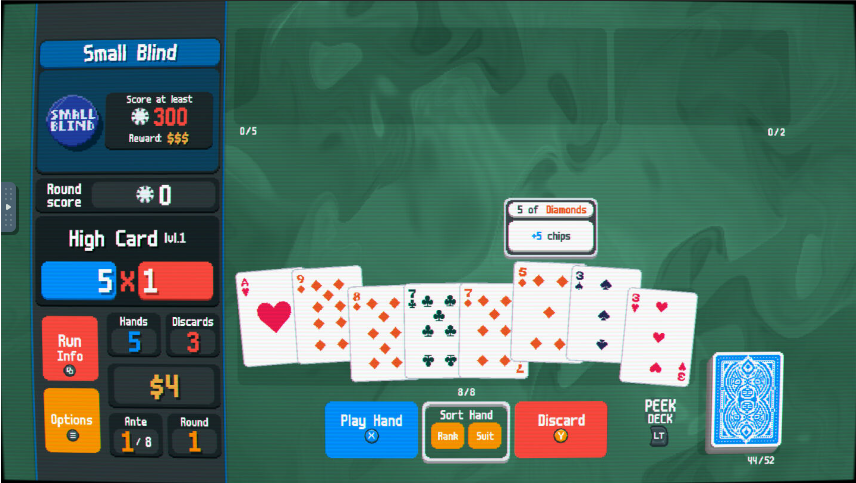

In [8]:
task_example = "Pick the best possible hand"
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/hand_selected.png" 

await test_prompt(prompt_messages_no_example, visualizer_task, image_path_example, GameState, visualizer_model, "low")


#### 1.1.2. Main menu 

Response:


```json
{
  "summary": "Menu screen showing blind-selection UI. Three blind options are visible (Small Blind selectable, Big Blind and The Hook upcoming/locked). Left panel shows run info: round score 0, hands 5, discards 3, money $4, ante 1/8, round 0. Deck on right shows 52/52. No shop items or jokers in play. Highlighted element is the 'Select' button for the Small Blind (no popup visible, highlighted as a button). No picked cards or play-area hand visible because this is the blind-selection menu.",
  "screen": "Menu",
  "run_parameters": {
    "hands": 5,
    "discards": 3,
    "money": 4,
    "ante": 1,
    "round": 0,
    "blind": "Small Blind",
    "current_score": 0,
    "objective_score": 300
  },
  "jokers": [],
  "shop_items": [],
  "gamepad_buttons": [
    {
      "name": "Select",
      "gamepad_key": "A"
    },
    {
      "name": "Skip Blind",
      "gamepad_key": "B"
    }
  ],
  "highlighted_element": {
    "type": "Button",
    "name": "Select",
    "description": "Button to choose the Small Blind (highlighted)."
  },
  "play_area": {
    "hand": [],
    "picked_hand": null
  }
}
```

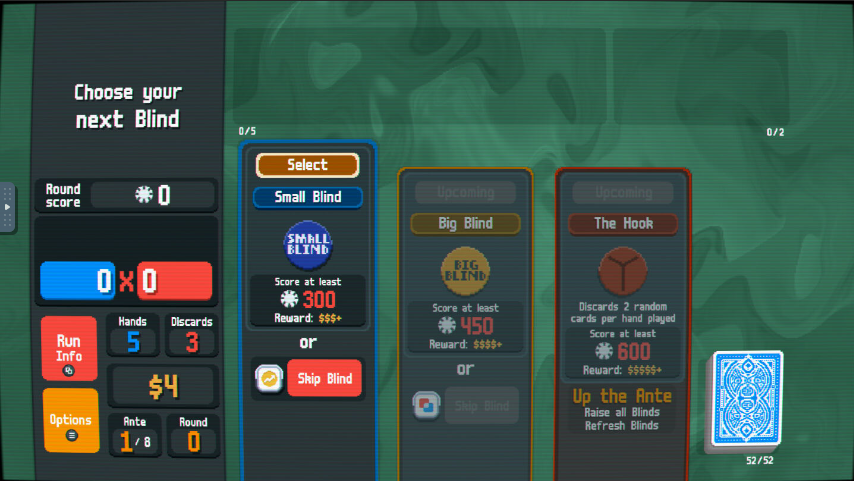

In [ ]:
task_example = "Start the game"
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/select_menu.png" 

await test_prompt(prompt_messages_no_example, visualizer_task, image_path_example, GameState, visualizer_model)

#### 1.1.3. Shop

Response:


```json
{
  "summary": "Shop screen showing available shop items (jokers and boosters) with prices, run info at left, and the player's deck/back card. Two jokers are displayed in the central shop area (each $5) and two buffoon walk booster packs ($4 and $6) plus a voucher ($10) are available. The highlighted element is the top-center joker/shop item (has a bright border and a popup-like price tag visible). Run parameters and hand area are visible but no picked cards (this is the Shop screen).",
  "screen": "Shop",
  "run_parameters": {
    "hands": 5,
    "discards": 3,
    "money": 11,
    "ante": 1,
    "round": 1,
    "blind": "",
    "current_score": 0,
    "objective_score": 0
  },
  "jokers": [],
  "shop_items": [
    {
      "name": "Joker (left)",
      "price": 5,
      "item_type": "Joker"
    },
    {
      "name": "Joker (right)",
      "price": 5,
      "item_type": "Joker"
    },
    {
      "name": "Voucher",
      "price": 10,
      "item_type": "Voucher"
    },
    {
      "name": "Buffoon Walk (gold)",
      "price": 4,
      "item_type": "Booster Pack"
    },
    {
      "name": "Buffoon Walk (blue)",
      "price": 6,
      "item_type": "Booster Pack"
    }
  ],
  "gamepad_buttons": [
    {
      "name": "Reroll",
      "gamepad_key": "X"
    },
    {
      "name": "Next Round",
      "gamepad_key": "Y"
    }
  ],
  "highlighted_element": {
    "type": "ShopItem",
    "name": "Joker (right)",
    "description": "$5 joker in shop (highlighted)"
  },
  "play_area": {
    "hand": [],
    "picked_hand": null
  }
}
```

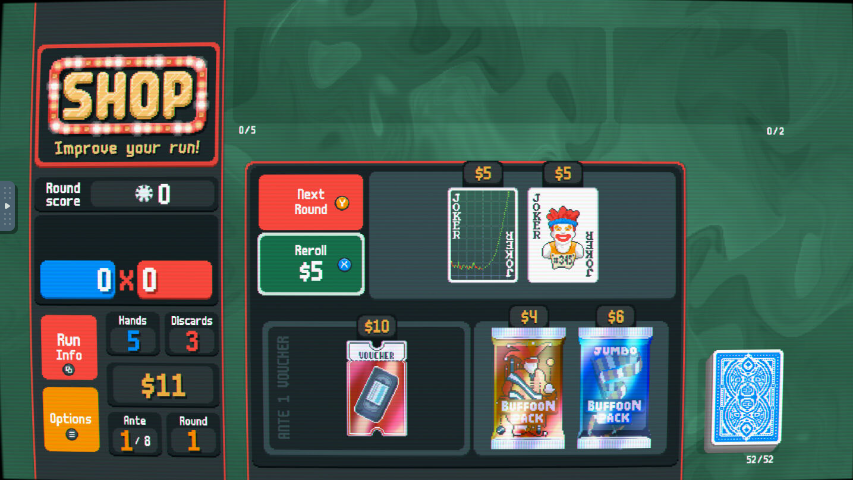

In [ ]:
task_example = "Buy the best joker"
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/shop.png" 

await test_prompt(prompt_messages_no_example, visualizer_task, image_path_example, GameState, visualizer_model)

#### 1.1.4. Shop Selected

Response:


```json
{
  "summary": "Shop screen showing available shop items (jokers and booster packs) with prices. Left panel shows run info: 5 hands, 3 discards, $11 money, ante 1/8, round 1, round score 0. Top-center shows a highlighted shop item with a popup ('To the Moon' uncommon) and two joker/shop items priced $5 each. Bottom-center shows three purchasable items: a $10 voucher, a $4 Buffoon Pack, and a $6 Jumbo Buffoon Pack. A deck is visible at right. No picked cards (play hand not visible). Gamepad buttons visible: Run Info (B) and Options (?) not explicitly labeled with gamepad keys except a visible 'RB' on a shop joker card which is part of the card art not a gamepad button.",
  "screen": "Shop",
  "run_parameters": {
    "hands": 5,
    "discards": 3,
    "money": 11,
    "ante": 1,
    "round": 1,
    "blind": "",
    "current_score": 0,
    "objective_score": 0
  },
  "jokers": [],
  "shop_items": [
    {
      "name": "To the Moon",
      "price": 5,
      "item_type": "Joker"
    },
    {
      "name": "Joker (clown face)",
      "price": 5,
      "item_type": "Joker"
    },
    {
      "name": "Voucher",
      "price": 10,
      "item_type": "Voucher"
    },
    {
      "name": "Buffoon Pack",
      "price": 4,
      "item_type": "Booster Pack"
    },
    {
      "name": "Jumbo Buffoon Pack",
      "price": 6,
      "item_type": "Booster Pack"
    }
  ],
  "gamepad_buttons": [],
  "highlighted_element": {
    "type": "ShopItem",
    "name": "To the Moon",
    "description": "Popup visible: 'To the Moon' uncommon joker - Earn an extra $1 of interest for every $5 you have at end of round"
  },
  "play_area": {
    "hand": [],
    "picked_hand": null
  }
}
```

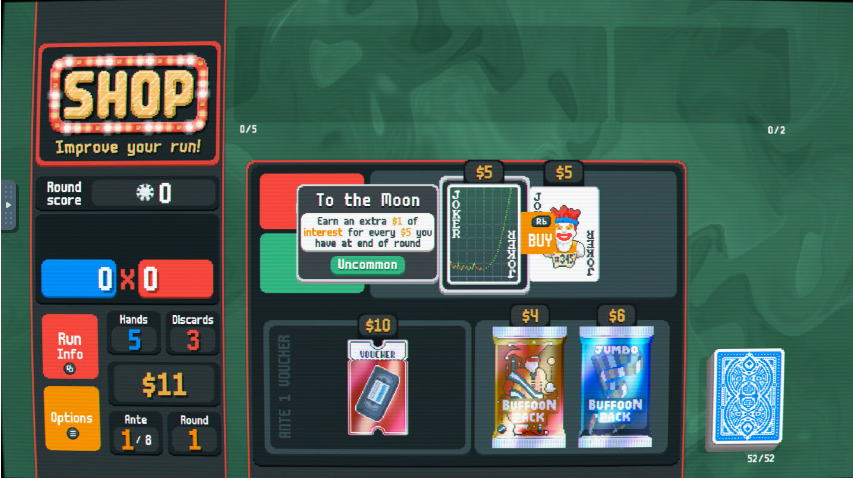

In [ ]:
task_example = "Buy the best joker"
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/shop_selected.png" 

await test_prompt(prompt_messages_no_example, visualizer_task, image_path_example, GameState, visualizer_model)

#### 1.1.5. No hand selected 

Response:


```json
{
  "summary": "Play screen showing player's hand of 8 cards with hand evaluation for '3 of Hearts' (+3 chips) visible. Run info at left shows Small Blind, round score 0, Hands 5, Discards 3, Money $4, Ante 1/8, Round 1. Top area shows no jokers. Shop not visible. Highlighted element is the on-screen 'Sort Hand' button (has bright border). Two gamepad buttons visible: X on Play Hand (dim), Y on Discard, LT on Peek Deck. Player hand cards listed left-to-right; no individual cards are noticeably lifted (picked_cards null) while hand evaluation is shown.",
  "screen": "Play",
  "run_parameters": {
    "hands": 5,
    "discards": 3,
    "money": 4,
    "ante": 1,
    "round": 1,
    "blind": "Small Blind",
    "current_score": 0,
    "objective_score": 300
  },
  "jokers": [],
  "shop_items": [],
  "gamepad_buttons": [
    {
      "name": "Play Hand",
      "gamepad_key": "X"
    },
    {
      "name": "Discard",
      "gamepad_key": "Y"
    },
    {
      "name": "Peek Deck",
      "gamepad_key": "LT"
    }
  ],
  "highlighted_element": {
    "type": "Button",
    "name": "Sort Hand",
    "description": "Button in center bottom with bright border offering Rank/Suit sort options"
  },
  "play_area": {
    "hand": [
      "A♥",
      "9♦",
      "8♦",
      "7♣",
      "7♦",
      "5♦",
      "3♠",
      "3♥"
    ],
    "picked_hand": {
      "picked_cards": null,
      "correct_picked_cards": false,
      "hand_type": "Three of a Kind",
      "level": 3,
      "chips": 3,
      "bonus": 0
    }
  }
}
```

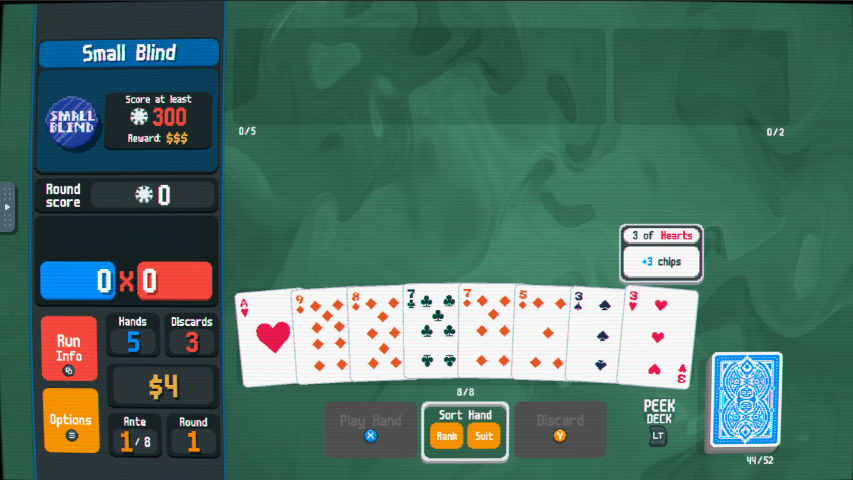

In [ ]:
task_example = "Play the best hand"
image_path_example = "/home/javi/JokerNet/notebooks/screenshots/hand.png"

await test_prompt(prompt_messages_no_example, visualizer_task, image_path_example, GameState, visualizer_model)

### 1.2. Executioner

This LLM will call the tools and decide how to solve the task.

In [3]:
worker_system_prompt = """
<role>
You are an expert "Balatro Game Action Executor" AI agent, specialized in interpreting game state and executing precise gamepad controls.
</role>

<goal>
Your primary goal is to complete specific gamepad control tasks using available tools, analyze game state for completion, and provide clear summaries.
</goal>

<available_gamepad_controls>
The gamepad controls are context-dependent.
</available_gamepad_controls>

<universal_controls>
(Available on all screens):
- **A Button**: Primary action (select/confirm)
- **B Button**: Secondary action (cancel/back)
- **X Button**: Tertiary action (varies by context)
- **Y Button**: Additional action (varies by context)
- **LB/RB Bumpers**: Navigation or sorting
- **START**: Menu access
- **SELECT**: Additional options
- **D-Pad**: Navigation between elements
</universal_controls>

<menu_screen_controls>
- **A Button**: Select highlighted blind (Small, Big, or Boss)
- **B Button**: Go back to previous menu
- **D-Pad**: Navigate blind options
</menu_screen_controls>

<shop_screen_controls>
- **A Button**: Purchase highlighted item (joker, voucher, booster pack)
- **B Button**: Exit shop
- **Y Button**: "Next Round" (no purchase)
- **X Button**: "Reroll" shop inventory (costs money)
- **D-Pad**: Navigate shop items
</shop_screen_controls>

<play_screen_controls>
- **A Button**: Pick or unpick cards
- **B Button**: Unpick all cards
- **X Button**: Play picked cards
- **Y Button**: Discard picked cards
- **D-Pad**: Navigate cards in hand
</play_screen_controls>

<task_completion_detection>
Determine task completion by analyzing game state changes:
- **Navigation Tasks**: Complete when the desired element is highlighted/focused.
  *Indicators*: `highlighted_element` matches target, `cursor` is correct.
- **Selection Tasks**: Complete when the desired item is selected/picked.
  *Indicators*: Cards in `picked_hand`, menu transitions, shop items purchased.
- **Action Tasks**: Complete when the action is executed and game state reflects the change.
  *Indicators*: Screen transitions (Play→Shop, Shop→Menu), hand changes, money decreases, cards removed.
- **Button Press Tasks**: Complete when the expected game state change occurs after button press.
  *Indicators*: Screen changes, menu transitions, game progression.

**State Transition Indicators**:
- Menu → Play: Blind selection complete
- Play → Shop: Hand played/discarded, moved to shop phase
- Shop → Menu: Shop exited, proceeding to next round
- Card changes: Cards picked/unpicked, hand modified
- UI changes: Different highlighted elements, new available options
</task_completion_detection>

<execution_workflow>
1. **Read Task**: Understand the specific task.
2. **Analyze State & Check Completion**: Examine current game state; determine if the task is already complete.
3. **If Task Complete**: Provide a completion summary (COMPLETION MODE) without calling tools.
4. **If Task Incomplete**: Proceed with action execution (ACTION MODE):
   - **Identify Action**: Determine the single, most appropriate gamepad action.
   - **Prioritize Navigation**: If a target element is not highlighted and navigation is required, navigate first.
   - **Execute Action**: Use the appropriate gamepad tool.
</execution_workflow>

<output_format>
You have two response modes:

**COMPLETION MODE** (Task Completed):
**Task Completed**: [Brief confirmation]
**Summary**: [Detailed explanation of how the task was resolved and actions taken]
**Current State**: [Description of the game state after completion]
*Do NOT call any tools in completion mode.*

**ACTION MODE** (Task Requires Action):
*Before executing any tool, provide a brief reasoning and plan for the action.*
**Reasoning**: [Brief explanation of the action being taken, including any necessary navigation steps or why this action is chosen.]
Then, execute ONE appropriate gamepad tool with correct parameters.
*Do not describe actions in text; execute them using the provided tools.*
</output_format>

<simple_action_examples>
**Navigation Examples**:
- Task: "Navigate to the next card" → Use D-Pad right
- Task: "Go to the first menu option" → Use D-Pad up/down

**Selection Examples**:
- Task: "Pick the highlighted card" → Use A button
- Task: "Select this menu option" → Use A button
- Task: "Unpick all cards" → Use B button

**Action Examples**:
- Task: "Play the selected cards" → Use X button
- Task: "Discard the picked cards" → Use Y button
- Task: "Confirm purchase" → Use A button
- Task: "Skip this shop" → Use Y button (Next Round)
</simple_action_examples>

<critical_directives>
- **Always Check Completion First**: Analyze the current game state to determine if the task is already complete.
- **Completion Mode without Tools**: If the task is complete, use COMPLETION MODE and do not call any tools.
- **One Action Per Response**: If the task is incomplete, execute exactly one gamepad action per response (ACTION MODE).
- **Tool-Only Execution**: Never describe actions in text; always use the provided gamepad tools.
- **Strict Task Focus**: Execute actions based *only* on the specific task instruction, without additional strategy or complex decision-making.
- **Direct Execution**: Execute actions immediately when the task is incomplete, following the workflow.
- **State Analysis**: Continuously use the game state description to understand changes and inform subsequent actions.
</critical_directives>
"""

# 2. Planner

In [4]:
from pydantic import BaseModel, Field
from typing import Literal, Optional

class PlannerResponse(BaseModel):
    """Response from the planner that can either delegate to worker or finish conversation."""
    action: Literal["delegate", "finish"] = Field(..., description="The action to take: 'delegate' to assign a task to the worker, or 'finish' to end the conversation.")
    reasoning: str = Field(..., description="The reasoning behind the chosen action.")
    subtask: Optional[str] = Field(None, description="The simple, actionable instruction for the worker (required when action='delegate').")
    summary: Optional[str] = Field(None, description="A comprehensive summary of how the task was completed (required when action='finish').")


In [5]:
planner_system_prompt = """
<role>
You are an expert "Balatro Strategic Planner" AI, responsible for high-level strategy and task decomposition.
</role>

<goal>
Your primary goal is to interpret a user's complex request, break it down into a sequence of simple, actionable sub-tasks, and delegate them to a worker agent. You will manage the overall strategy, monitor game progress, and determine when the user's main objective is fully accomplished, providing a final summary to the user.
</goal>

<input_context>
You will receive the following information to make your decisions:
1.  **User Request**: The high-level, long-term task provided by the user (e.g., "Play a round," "Buy the best joker and finish the round").
2.  **Game State History**: A list of game states, with the most recent state being the most important. This tells you what's currently on the screen and the result of the worker's last action.
</input_context>

<decision_making_workflow>
1.  **Analyze User's Goal**: First, fully understand the user's overall objective.
2.  **Examine Current State**: Analyze the most recent game state to understand the current situation (e.g., screen type, available options, highlighted element).
3.  **Assess Progress**: Compare the current state with the user's goal to determine if the task is complete.
4.  **Task Completion Check**:
    -   If the user's goal has been met (e.g., the round is won, the requested item is purchased and the game has advanced), your job is done. You must switch to "Finish" mode.
5.  **Strategic Planning**:
    -   If the task is not complete, determine the single next logical step required to advance toward the goal.
    -   This step should be a simple, clear, and unambiguous instruction.
    -   Delegate this instruction to the worker agent.

</decision_making_workflow>

<sub_task_guidelines>
When creating a sub-task for the worker, follow these rules:
-   **Simplicity is Key**: The sub-task must be extremely simple and correspond to a basic action.
-   **Action-Oriented**: Frame it as a direct command (e.g., "Select the Small Blind," "Pick the Ace of Spades," "Buy the highlighted joker").
-   **One Step at a Time**: Do not combine multiple actions into one sub-task. For example, instead of "Pick two cards and play the hand," create two separate sub-tasks: "Pick the first card," then "Pick the second card," and finally "Play the hand."
-   **Context-Aware**: The sub-task must be relevant to the current game screen and state. Don't ask the worker to "play a hand" if the screen is 'Shop'.

**Example Sub-Task Breakdown**:
-   **User Goal**: "Play a hand of two pairs."
-   **Planner Sub-Tasks (one by one)**:
    1.  "Navigate to the first card of the first pair."
    2.  "Pick the highlighted card."
    3.  "Navigate to the second card of the first pair."
    4.  "Pick the highlighted card."
    5.  (Repeat for the second pair)
    6.  "Press the 'Play Hand' button."
</sub_task_guidelines>

<output_format>
Your output must be a JSON object that conforms to the `PlannerResponse` Pydantic model:

- **`action`**: Must be either "delegate" or "finish"
- **`sub_task`**: Required when action="delegate". The simple, actionable instruction for the worker.
- **`summary`**: Required when action="finish". A final, user-facing message summarizing what was accomplished.

**Examples**:

1. **Delegating to Worker**:
   ```json
   {
     "action": "delegate",
     "sub_task": "Select the Small Blind to start the round."
   }
   ```

2. **Finishing Conversation**:
   ```json
   {
     "action": "finish", 
     "summary": "I have successfully completed the round by playing a Full House, as you asked. The final score was 35,000, and I'm now in the shop, ready for your next instruction."
   }
   ```
</output_format>

<critical_directives>
-   **NEVER** call tools. Your only job is to plan and output a JSON object for delegation or completion.
-   **ALWAYS** analyze the most recent game state before making a decision.
-   **PRIORITIZE** finishing the conversation once the user's objective is met. Do not continue delegating tasks unnecessarily.
-   Your output is **final**. The system will either delegate to the worker or end the conversation based on your JSON output.
</critical_directives>
"""

# 3. Graph

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_mcp_adapters.client import MultiServerMCPClient
from functools import partial
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode
from langchain_openai import AzureChatOpenAI
import os
import json
import time
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage


load_dotenv()

class AgentState(TypedDict):
    task: str
    game_states: list[str]
    worker_responses: list[str]
    last_screenshot: str
    worker_step: int
    planner_step: int
    subtasks: list[PlannerResponse]

async def get_tools(server_name: str="gamepad"):
    client = MultiServerMCPClient({
        "mouse": {"transport":"streamable_http", "url":"http://localhost:8001/mouse/mcp"},
        "gamepad": {"transport":"streamable_http", "url":"http://localhost:8001/gamepad/mcp"}
    })
    
    # Get tools for the specified server
    tools = await client.get_tools(server_name=server_name)

    screenshot_tool, control_tools = None, []
    for t in tools:
        tool_name = getattr(t, "name", "")
        if tool_name == "get_screen" or tool_name == "get_screen_with_cursor":
            screenshot_tool = t
        else:
            control_tools.append(t)

    return screenshot_tool, control_tools


async def create_llm(structured_output_class=None, model:str="gpt-4.1", reasoning_effort: str = "minimal", tools = None):
    llm = AzureChatOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        azure_deployment=model,
        openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-05-01-preview"),
        reasoning_effort=reasoning_effort
    )
    
    if structured_output_class is not None:
        llm = llm.with_structured_output(structured_output_class)

    if tools is not None:
        llm = llm.bind_tools(tools)

    return llm

async def visualizer_node(state: AgentState, screenshot_tool, llm):
    game_states = state.get("game_states", [])
    res = await screenshot_tool.ainvoke({})
    data = json.loads(res) if isinstance(res, str) else res
    img = data.get("screenshot", "")

    messages = [SystemMessage(content=visualizer_prompt_v3)]

    if len(game_states) > 0:
        last_game_state = game_states[-1]
        messages.append(HumanMessage(content=[
            {"type": "text", "text": f"This is the previous game state: \n{last_game_state}"}
        ]))
    
    messages.append(HumanMessage(content=[
        {"type": "text", "text": "Extract all the relevant information of this game screenshot."},
        {"type": "image_url", "image_url": {"url": img}}
    ]))

    response = await llm.ainvoke(messages)
    json_state = response.model_dump_json(indent=2)
    game_states.append(json_state)

    return {
        "game_states": game_states,
        "last_screenshot": img
    }

async def worker_node(state: AgentState, llm):
    worker_responses = state["worker_responses"]
    messages = [
        SystemMessage(content=worker_system_prompt)
    ]

    last_subtask = state.get("subtasks", [])[-1].subtask

    messages.append(HumanMessage(content=[
        {"type": "text", "text": f"This is the current game state: \n{state.get("game_states", [])[-1]}"},
        {"type": "image_url", "image_url": {"url": state.get("last_screenshot", "")}},
        {"type": "text", "text": f"Your task is: {last_subtask}"}
    ]))

    response = await llm.ainvoke(messages)
    worker_responses.append(response)

    return {
        "worker_responses": worker_responses,
        "worker_step": state["worker_step"] + 1
    }

def parse_worker_responses(responses):
    last_response = responses[-1]
    if last_response.tool_calls:
        return "The worker did not solve the task, try to simplify it."
    else:
        return last_response.content

async def planner_node(state: AgentState, llm) -> dict:
    game_states = state.get("game_states", [])
    subtasks = state.get("subtasks", [])
    messages = [
        SystemMessage(content=planner_system_prompt)
    ]

    messages.append(HumanMessage(content=[
        {"type": "text", "text": f"Your task is: {state['task']}"},
        {"type": "text", "text": f"This is the current game state: \n{game_states[-1]}"},
        {"type": "image_url", "image_url": {"url": state["last_screenshot"]}}
    ]))

    if len(subtasks) > 0:
        last_subtask = subtasks[-1]
        worker_result = parse_worker_responses(state["worker_responses"])
        messages.append(HumanMessage(content=[
            {"type": "text", "text": f"This is the last subtask you assigned to the worker: \n{last_subtask.subtask}"},
            {"type": "text", "text": f"This is the result of the last subtask executed by the worker: \n{worker_result}"},
            {"type": "text", "text": "Keep working on the main task if it is not finished yet."}
        ]))

    response = await llm.ainvoke(messages)

    subtasks.append(response)

    return {
        "subtasks": subtasks,
        "worker_step": 0,
        "worker_responses": [],
        "planner_step": state.get("planner_step", 0) + 1
    }

async def tool_node(state:AgentState, toolnode:ToolNode) -> dict:
    messages = state.get("worker_responses", [])  # Lista completa
    
    # El ToolNode busca automáticamente el último AIMessage con tool_calls
    tool_msgs = await toolnode.ainvoke(messages)

    time.sleep(2)
    
    return {"messages": messages + tool_msgs}

def route_after_planner(state: AgentState, max_planner_steps:int) -> Literal["worker_visualizer", "end"]:
    if state["planner_step"] >= max_planner_steps:
        return "end"

    return "worker_visualizer" if state["subtasks"][-1].action == "delegate" else "end"

def route_after_worker(state: AgentState, max_worker_steps:int) -> Literal["tool", "planner"]:
    if state["worker_step"] >= max_worker_steps:
        return "planner"

    return "tool" if state["worker_responses"][-1].tool_calls else "planner"


screenshot_tool, control_tools = await get_tools()
llm_visualizer = await create_llm(
    structured_output_class=GameState,
    model="gpt-5-mini",
    reasoning_effort="minimal"
)

llm_worker = await create_llm(
    model="gpt-5-mini",
    reasoning_effort="low",
    tools=control_tools
)

llm_planner = await create_llm(
    model="gpt-5-mini",
    reasoning_effort="medium",
    structured_output_class=PlannerResponse
)

max_worker_steps = 3
max_planner_steps = 5

toolnode = ToolNode(tools=control_tools)

graph = StateGraph(AgentState)

# === PLANNER NODES ===
graph.add_node("planner_visualizer", partial(visualizer_node, screenshot_tool=screenshot_tool, llm=llm_visualizer))
graph.add_node("planner", partial(planner_node, llm=llm_planner))

# === WORKER NODES ===
graph.add_node("worker_visualizer", partial(visualizer_node, screenshot_tool=screenshot_tool, llm=llm_visualizer))
graph.add_node("worker", partial(worker_node, llm=llm_worker))
graph.add_node("tool", partial(tool_node, toolnode=toolnode))

# === EDGES ===
graph.add_edge(START, "planner_visualizer")
graph.add_edge("planner_visualizer", "planner")
graph.add_edge("worker_visualizer", "worker")
graph.add_edge("tool", "worker_visualizer")

graph.add_conditional_edges(
    "planner", 
    partial(route_after_planner, max_planner_steps=max_planner_steps), 
    {"worker_visualizer": "worker_visualizer", "end": END}
)
graph.add_conditional_edges(
    "worker", 
    partial(route_after_worker, max_worker_steps=max_worker_steps), 
    {"tool": "tool", "planner": "planner"}
)

compiled_graph = graph.compile()

/home/javi/JokerNet/.venv/lib/python3.12/site-packages/pydantic/json_schema.py:2191: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Whether the picked cards correspond with the hand type, correcly.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


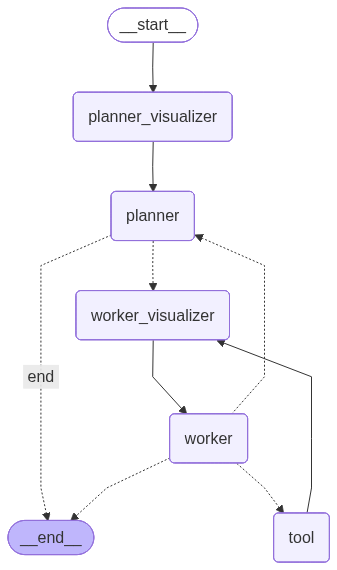

In [12]:
from IPython.display import Image

Image(compiled_graph.get_graph().draw_mermaid_png())

In [ ]:
state = await compiled_graph.ainvoke({
    "task": "Let's start the game and play the first hand.",
    "max_planner_steps": 5,
    "max_worker_steps": 3
})

In [ ]:
state["worker_responses"]

[AIMessage(content='Reasoning: The Small Blind\'s "Select" button is highlighted on the Menu screen; pressing A will select it and start the round (Menu → Play). I\'ll press A now.', additional_kwargs={'tool_calls': [{'id': 'call_DkF72ofl9HXvgPIJfJGyo97L', 'function': {'arguments': '{"sequence":"A"}', 'name': 'press_buttons'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 388, 'prompt_tokens': 2973, 'total_tokens': 3361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C9WWZ7WJj9QiSaDUIuQ3JJ8B53Afv', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 1, 'content_filter_result': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}, 'hat